In [46]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split

In [47]:
class CatNet(nn.Module):
    def __init__(self, inputsize, outputsize):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(32768, outputsize),
        ) 
    def forward(self, x):
        return self.model(x)


In [48]:
train_dataset = torch.load("datasets/train.pt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
test_dataset = torch.load("datasets/test.pt")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [49]:
num_epochs = 10
learning_rate = 0.01
weight_decay = 0.1
model = CatNet(16, 18)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
loss_history = []

for i in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        predictions = model.forward(x_batch)

        loss = criterion(predictions, y_batch)

        # Backward
        loss.backward()

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

        loss_history.append(loss.item())
    print(f'{i+1}/{num_epochs} current loss: {loss}')   

KeyboardInterrupt: 

In [ ]:
x, y = train_dataset[0]

C:\Users\Oleg\AppData\Local\Temp\ipykernel_18100\2365308143.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y, 'ro', color = 'red')


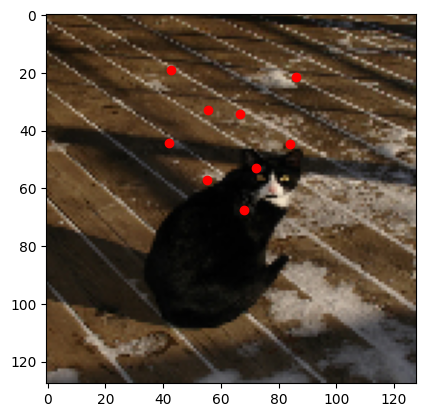

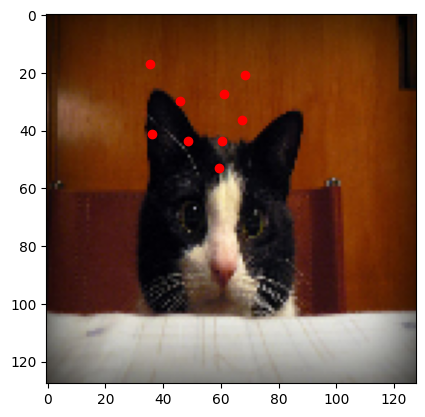

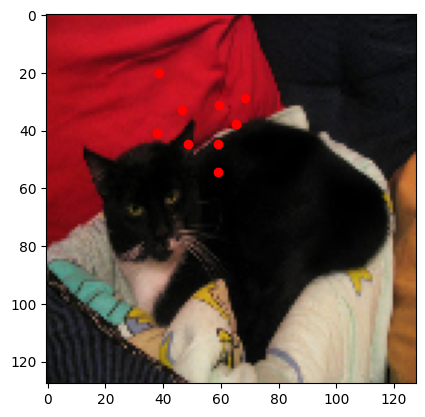

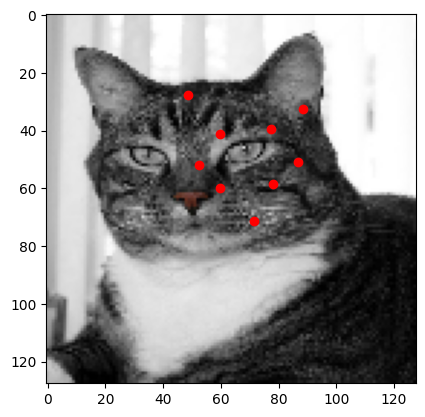

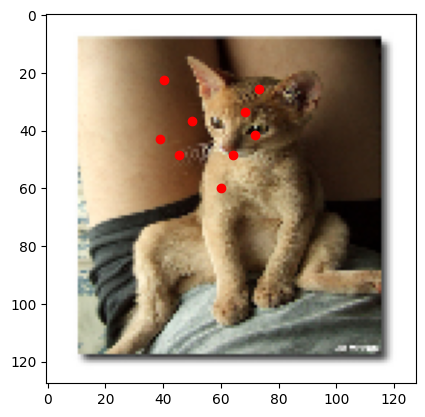

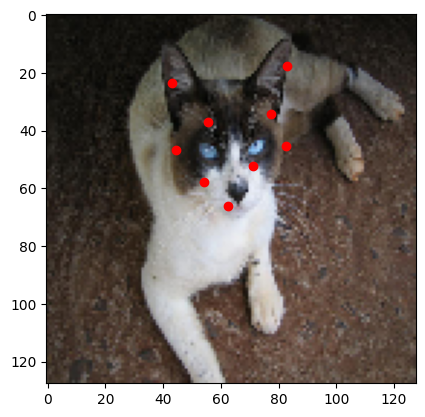

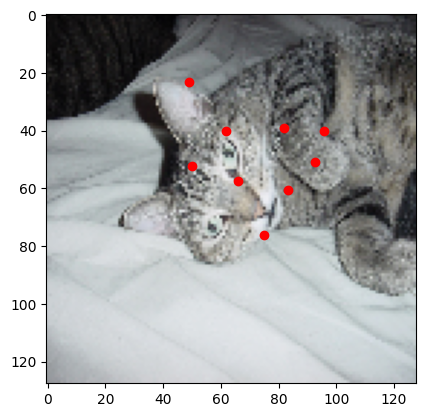

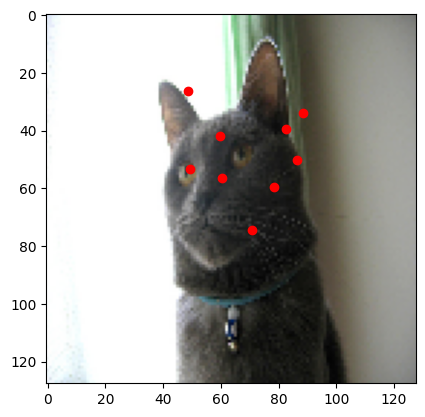

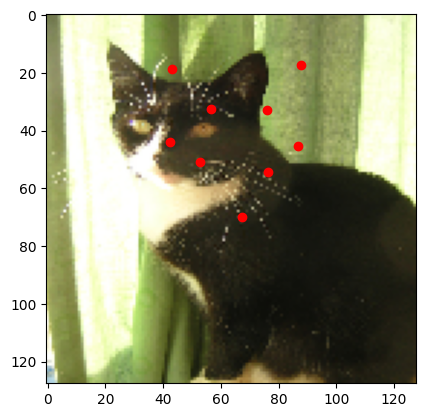

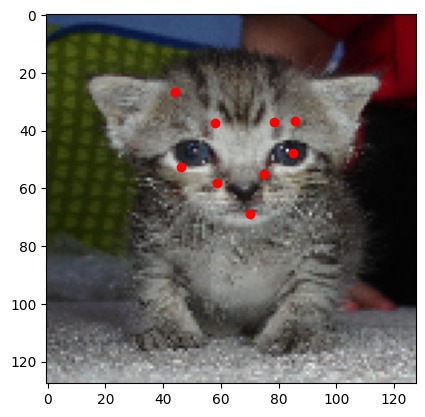

In [ ]:
for i in range(10):
    x, y = test_dataset[i]

    draw_img = x.type('torch.IntTensor')
    draw_points = model.forward(torch.stack([x]))[0].detach().numpy()
    #draw_right_points = y.detach().numpy()
    plt.imshow(draw_img.permute(1,2,0))
    for i in range(0, len(draw_points),2):
                x, y = draw_points[i], draw_points[i+1] 
                plt.plot(x,y, 'ro', color = 'red')
    #for i in range(0, len(draw_right_points),2):
                #x, y = draw_right_points[i], draw_right_points[i+1] 
                #plt.plot(x,y, 'ro', color = 'blue')
    plt.show()